<a href="https://colab.research.google.com/github/plural-ok/Japan-Term-Project-Repo/blob/main/JPN_Term_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import io
import os

import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt

# New package
from sklearn import tree
from sklearn import neighbors as nn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import neighbors as nn
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

A brief outline of what I am looking to determine.
Using inflation rate and whatever good data sources I can find, I am looking to determine Public Approval of Government in Japan using a variety of different models.


Preprocessing to format data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

pathname = "/content/drive/My Drive/JPN Term Proj/"
os.chdir(pathname)

Mounted at /content/drive


In [ ]:
filename = "rmain.xlsx" #Potential -> "hor_elections.xlsx"
dt1 = pd.read_excel(filename, sheet_name="ApprovalRate")
dt2 = pd.read_excel(filename, sheet_name="Predictors")
##filename = "pdy_jp.xlsx"
##dtp = pd.read_excel(filename, sheet_name="info_parties2")


In [ ]:
dt = pd.merge(dt1,dt2,  on='Time')
dt.columns


Index(['Time', 'appr', 'dppr', 'ifr', 'unemp'], dtype='object')

In [ ]:
dt


,Time,appr,dppr,ifr,unemp
0,2019-01-01,43,35,0.2,5.0
1,2019-02-01,44,37,0.2,4.7
2,2019-03-01,42,36,0.5,4.9
3,2019-04-01,47,35,0.9,4.8
4,2019-05-01,48,32,0.7,4.5
...,...,...,...,...,...
66,2024-08-01,25,55,3.0,4.9
67,2024-09-01,20,60,2.5,4.8
68,2024-10-01,44,32,2.3,4.9
69,2024-11-01,41,35,2.9,4.9


Graphs of our data frame.

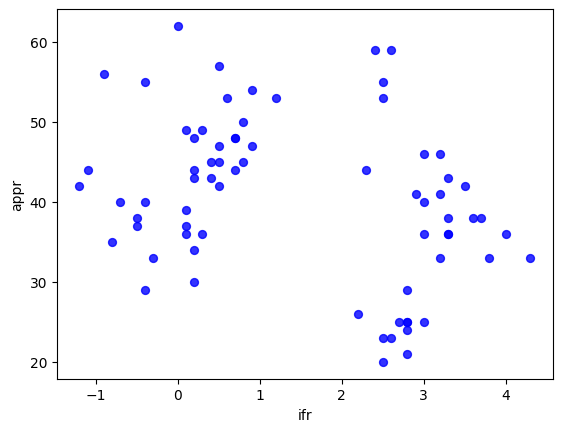

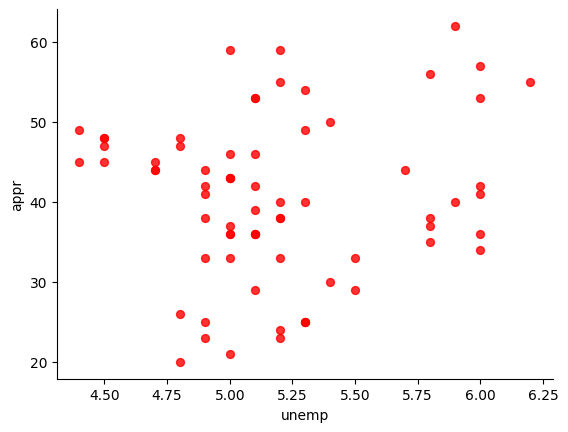

In [ ]:
dt.plot(kind='scatter', x='ifr', y='appr', s=32, alpha=.8, color = 'blue')
dt.plot(kind='scatter', x='unemp', y='appr', s=32, alpha=.8, color='red')

plt.gca().spines[['top', 'right',]].set_visible(False)

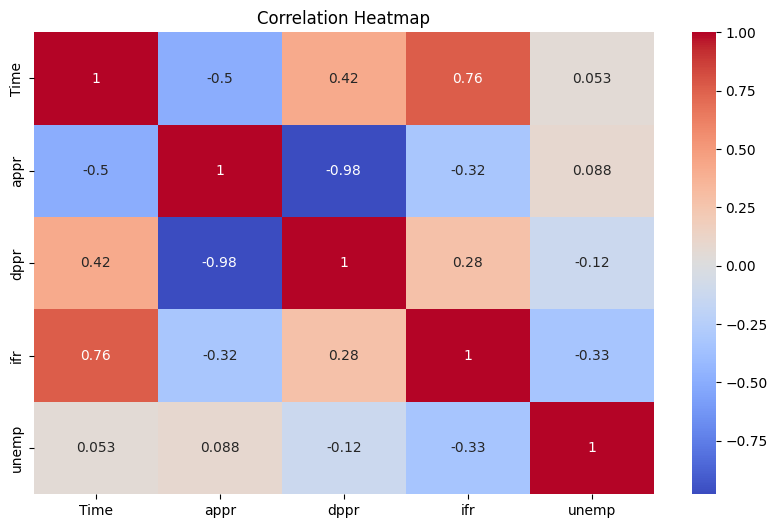

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(dt.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Naive Bayesian Model -> Classifies based on conditional probability

In [ ]:
X = dt[["ifr","unemp"]]
y = dt["appr"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=0)

gnb = GaussianNB()
gnbF = gnb.fit(X_train, y_train)

In [ ]:
# Accuracy on Training Data
exp = gnb.predict(X_train)
obs = y_train

print("\n\nTraining Accuracy")
print("Out of",len(exp),"trials, this model was accurate for",sum(exp==obs),"observations in the training set. This is a rate of",sum(exp==obs)/len(exp))




Training Accuracy
Out of 47 trials, this model was accurate for 29 observations in the training set. This is a rate of 0.6170212765957447


In [ ]:
# Accuracy on Test Data
exp = gnbF.predict(X_test)
obs = y_test

print("\n\nTesting Accuracy")
print("Out of",len(exp),"trials, this model was accurate for",sum(exp==obs),"observations in the test set. This is a rate of",sum(exp==obs)/len(exp))




Testing Accuracy
Out of 24 trials, this model was accurate for 1 observations in the test set. This is a rate of 0.041666666666666664


Decision Tree Classifier

In [ ]:
# Create approval categories using pd.cut
dt['approval_category'] = pd.cut(dt['appr'],
                                   bins=[0, 39, float('inf')],
                                   labels=['Low Approval', 'Hi Approval'],
                                   include_lowest=True,
                                   right=True)

# Now use the new 'approval_category' column as the target variable
features = dt[["ifr","unemp"]]
target = dt["approval_category"]

In [ ]:
indexTrain = np.ones(len(features), dtype=bool)
indexTrain[ np.arange(0,7,1) ] = False
featuresTrain = features[indexTrain]
targetTrain   = target[indexTrain]

featuresTest = features[~indexTrain]
targetTest   = target[~indexTrain]

In [ ]:
stTree = tree.DecisionTreeClassifier(max_depth= 8, criterion="gini")
stTree.fit(featuresTrain, targetTrain)

DecisionTreeClassifier(max_depth=8)

In [ ]:
# Accuracy on Training Data
exp = stTree.predict(featuresTrain)
obs = targetTrain

print("\n\nTraining Accuracy")
print("Out of",len(exp),"trials, this model was accurate for",sum(exp==obs),"observations in the training set. This is a rate of",sum(exp==obs)/len(exp))




Training Accuracy
Out of 64 trials, this model was accurate for 61 observations in the training set. This is a rate of 0.953125


In [ ]:
# Accuracy on Test Data
exp = stTree.predict(featuresTest)
obs = targetTest

print("\n\nTesting Accuracy")
print("Out of",len(exp),"trials, this model was accurate for",sum(exp==obs),"observations in the test set. This is a rate of",sum(exp==obs)/len(exp))




Testing Accuracy
Out of 7 trials, this model was accurate for 6 observations in the test set. This is a rate of 0.8571428571428571


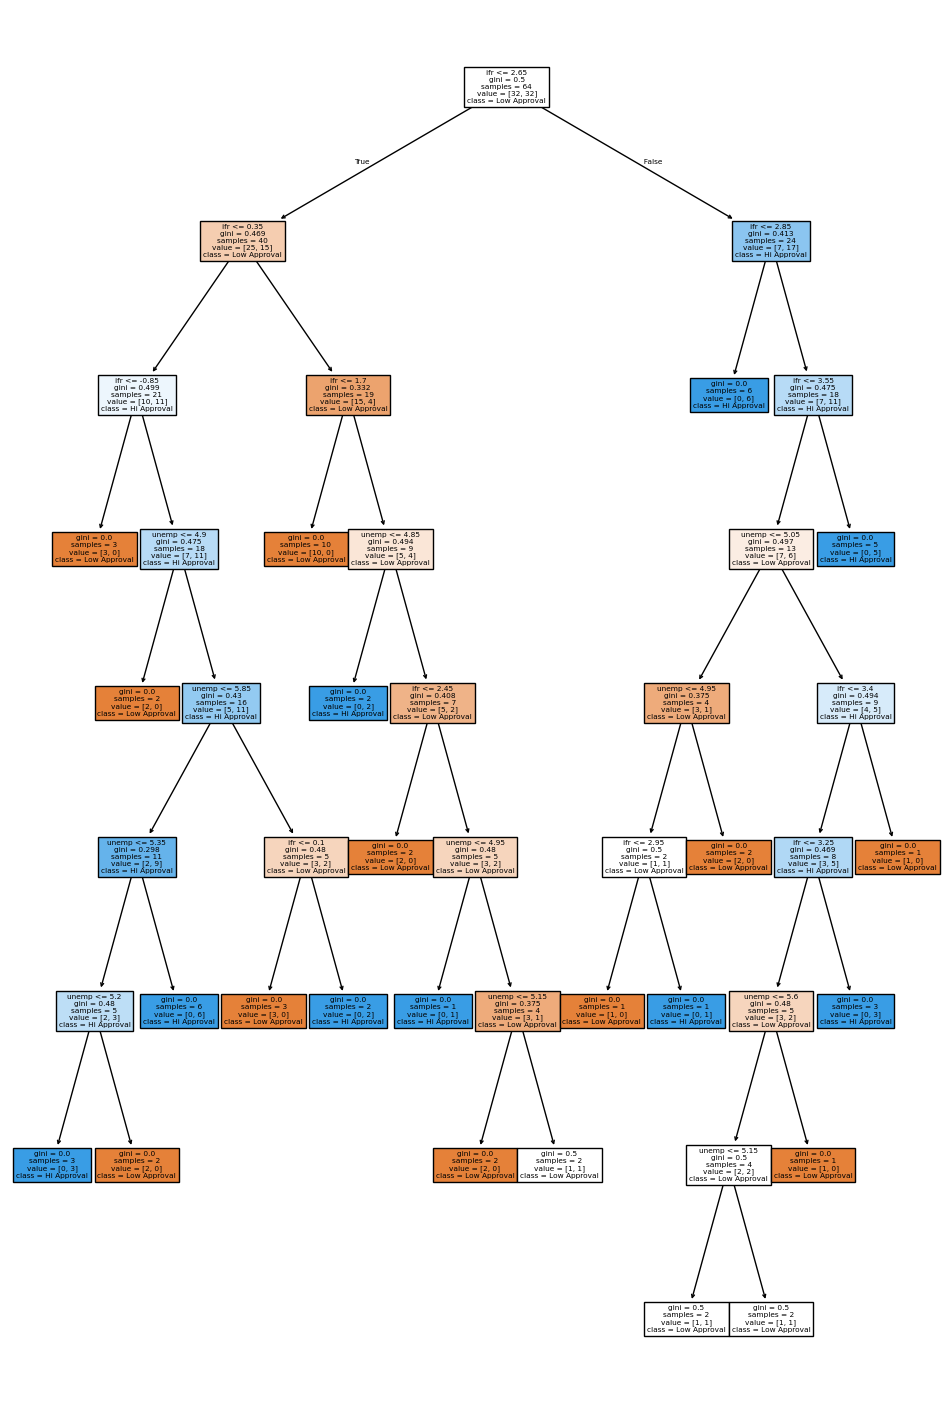

In [ ]:
# When plotting the tree, you can directly use the labels:
plt.figure(figsize=(12, 18))
tree.plot_tree(stTree, feature_names=features.columns,
               class_names=['Low Approval', 'Hi Approval'],
               filled=True)
plt.show()

Confusion Matrix for our Model



In [ ]:
confusion_matrix(stTree.predict(featuresTest), targetTest)

array([[6, 0],
       [1, 0]])

Adaboosting Our Model - Cloning and Consolidating

In [ ]:
features = dt[["ifr","unemp"]]
target = dt["approval_category"]

In [ ]:
indexTrain = np.ones(len(features), dtype=bool)
indexTrain[ np.arange(0,30,3) ] = False
featuresTrain = features[indexTrain]
targetTrain   = target[indexTrain]

featuresTest = features[~indexTrain]
targetTest   = target[~indexTrain]

In [ ]:
abc = AdaBoostClassifier(
    DecisionTreeClassifier( max_depth=12, random_state=370, criterion='gini'),
    n_estimators=100, random_state=370 )

abc.fit(featuresTrain, targetTrain)


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=12,
                                                    random_state=370),
                   n_estimators=100, random_state=370)

In [ ]:
# Accuracy on Training Data
exp = abc.predict(featuresTrain)
obs = targetTrain

print("\n\nTraining Accuracy")
print("Out of",len(exp),"trials, this model was accurate for",sum(exp==obs),"observations in the training set. This is a rate of",sum(exp==obs)/len(exp))




Training Accuracy
Out of 61 trials, this model was accurate for 60 observations in the training set. This is a rate of 0.9836065573770492


In [ ]:
# Accuracy on Test Data
exp = abc.predict(featuresTest)
obs = targetTest

print("\n\nTesting Accuracy")
print("Out of",len(exp),"trials, this model was accurate for",sum(exp==obs),"observations in the test set. This is a rate of",sum(exp==obs)/len(exp))




Testing Accuracy
Out of 10 trials, this model was accurate for 8 observations in the test set. This is a rate of 0.8


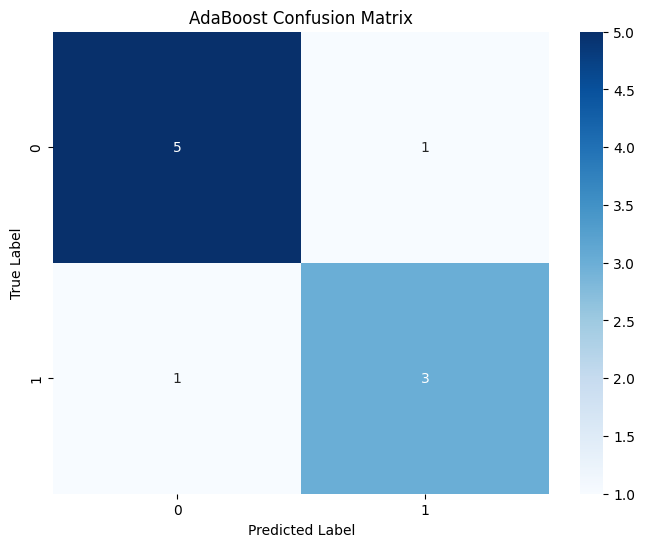

In [ ]:
y_pred = abc.predict(featuresTest)
y_test = targetTest
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('AdaBoost Confusion Matrix')
plt.show()

Multiple Regression Line



In [ ]:
X = dt[["ifr","unemp"]]
y = dt["appr"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
mod1 = LinearRegression()

mod1.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Accuracy on Training Data
exps = mod1.predict(X_train)
exp = np.round(exps)
obs = y_train

print("\n\nTraining Accuracy")
print("Out of",len(exp),"trials, this model was accurate for",sum(exp==obs),"observations in the training set. This is a rate of",sum(exp==obs)/len(exp))




Training Accuracy
Out of 56 trials, this model was accurate for 1 observations in the training set. This is a rate of 0.017857142857142856


In [ ]:
exp

array([45., 38., 44., 38., 37., 43., 42., 36., 45., 41., 37., 36., 36.,
       34., 44., 38., 39., 44., 38., 42., 36., 41., 44., 38., 42., 37.,
       41., 42., 38., 38., 37., 43., 46., 38., 46., 37., 45., 38., 37.,
       41., 43., 38., 38., 41., 44., 37., 37., 42., 36., 46., 42., 46.,
       46., 38., 43., 37.])

In [ ]:
obs

,appr
30,29
59,26
35,57
58,23
42,46
16,36
34,50
44,38
28,37
7,49
